# Autogluon Classifier

Install Autogluon and Bokeh(2.0.1) for Autogluon plots. Autogluon works with Python 3.8 to 3.11

In [292]:
import numpy as np
import pandas as pd
import autogluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import bokeh

# Data Preprocessing

In [293]:
df0= pd.read_csv('Sample_Market_SKU_data.csv')
df0.shape
df0.head()

,Market,Sales Product,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,...,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01
0,AFRICA,AB12345,305,302,1503,1471,1583,2080,1490,672,...,787,1417,847,777,1128,1427,846,1475,1572,927
1,ASIA,AB12346,1892,1071,2065,841,1542,2142,691,103,...,615,1166,1538,1206,1129,290,426,762,1775,777
2,OCEANIA,AC12347,1728,1912,193,102,465,1279,1748,1817,...,1834,1392,1746,759,2258,2062,223,142,635,1295
3,EUROPE,AD12348,776,1499,660,1127,214,174,351,1184,...,561,316,1961,1005,1936,331,432,873,1753,870
4,NORTH AMERICA,AS12349,720,1101,1516,1395,967,44,638,521,...,975,1329,933,310,1533,1836,1644,2095,2268,1076


In [294]:
#Create a new column SKUMARKET. This will be our ITEM ID
df0["SKUMarket"] = df0["Market"] + "_"+ df0["Sales Product"]
#Drop the original Market and Sales columns
df=df0.iloc[:,2:]
#Move column 'SKUMarket' to first position 
col=df.pop('SKUMarket') 
df.insert(0, col.name, col)
df.head()


,SKUMarket,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,...,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01
0,AFRICA_AB12345,305,302,1503,1471,1583,2080,1490,672,472,...,787,1417,847,777,1128,1427,846,1475,1572,927
1,ASIA_AB12346,1892,1071,2065,841,1542,2142,691,103,1185,...,615,1166,1538,1206,1129,290,426,762,1775,777
2,OCEANIA_AC12347,1728,1912,193,102,465,1279,1748,1817,1494,...,1834,1392,1746,759,2258,2062,223,142,635,1295
3,EUROPE_AD12348,776,1499,660,1127,214,174,351,1184,225,...,561,316,1961,1005,1936,331,432,873,1753,870
4,NORTH AMERICA_AS12349,720,1101,1516,1395,967,44,638,521,523,...,975,1329,933,310,1533,1836,1644,2095,2268,1076


# Create an Autogluon DataFrame with timestamp, id_column and target


In [295]:
# Convert the DataFrame into long format
df_long = pd.melt(
    df,
    id_vars=['SKUMarket'],  # Columns to keep
    var_name='timestamp',                      # Name for the new column with variable names
    value_name='target'                    # Name for the new column with values
)

# Display the first few rows of the transformed data
df_ag=df_long.sort_values(by=['SKUMarket','timestamp'])
df_ag = df_ag.rename(columns={df_ag.columns[0]: 'item_id'})
df_ag

,item_id,timestamp,target
0,AFRICA_AB12345,2021-12-01,305
19,AFRICA_AB12345,2022-01-01,302
38,AFRICA_AB12345,2022-02-01,1503
57,AFRICA_AB12345,2022-03-01,1471
76,AFRICA_AB12345,2022-04-01,1583
...,...,...,...
606,OCEANIA_AC12350,2024-07-01,1394
625,OCEANIA_AC12350,2024-08-01,1568
644,OCEANIA_AC12350,2024-09-01,2056
663,OCEANIA_AC12350,2024-10-01,651


In [296]:
#Change DTYPE or else Autogluon will give you an error
df_ag['target'] = pd.to_numeric(df_ag['target'], errors='coerce')
df_ag['timestamp'] = pd.to_datetime(df_ag['timestamp'], errors='coerce')
df_ag['item_id'] = df_ag['item_id'].astype(str)
df_ag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 0 to 682
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item_id    684 non-null    object        
 1   timestamp  684 non-null    datetime64[ns]
 2   target     684 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 21.4+ KB


In [297]:
train_data = TimeSeriesDataFrame.from_data_frame(df_ag, timestamp_column="timestamp", id_column="item_id")
train_data

target
item_id         timestamp         
AFRICA_AB12345  2021-12-01     305
                2022-01-01     302
                2022-02-01    1503
                2022-03-01    1471
                2022-04-01    1583
...                            ...
OCEANIA_AC12350 2024-07-01    1394
                2024-08-01    1568
                2024-09-01    2056
                2024-10-01     651
                2024-11-01     376

[684 rows x 1 columns]

In [298]:
# Model fit
predictor = TimeSeriesPredictor(
    prediction_length=3,
    path="autogluon-target-monthly",
    target="target",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'C:\Users\neogi\Documents\Python_venv\autogluon-target-monthly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       17.29 GB / 31.64 GB (54.7%)
Disk Space Avail:   372.20 GB / 475.50 GB (78.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 684 rows, 19 time s

In [302]:
#The forecast always includes predictions for the next prediction_length timesteps, starting from the end of each time series in train_data.
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id        timestamp                                                     
AFRICA_AB12345 2024-12-01  1136.564368  321.740277  546.386216  758.819749   
               2025-01-01   950.070121  176.534887  383.206218  559.903979   
               2025-02-01   951.836478  142.812626  378.375012  584.390488   
AFRICA_AB12347 2024-12-01   936.878324  127.389156  333.502145  551.058471   
               2025-01-01   862.460571   26.135116  243.783355  436.997295   

                                  0.4          0.5          0.6          0.7  \
item_id        timestamp                                                       
AFRICA_AB12345 2024-12-01  975.199477  1136.564359  1291.946759  1464.294870   
               2025-01-01  778.646034   950.070126  1156.412980  1324.812139   
               2025-02-01  780.102542   951.836478  1158.164119  1356.446882   
AFRICA_AB12347 2024-12-01  765.721855   936.878324  1106.531040  1295.146725   
               2025-01-01  670.918911   862.460571  1088.675891  1284.321781   

                                   0.8          0.9  
item_id        timestamp                             
AFRICA_AB12345 2024-12-01  1681.366481  1970.893653  
               2025-01-01  1552.863477  1925.847018  
               2025-02-01  1590.474870  1968.239924  
AFRICA_AB12347 2024-12-01  1540.820559  1886.585339  
               2025-01-01  1548.117455  1973.383034

In [315]:
#Import test set
test = pd.read_csv('Sample_Market_SKU_test2.csv')
# Convert the DataFrame into long format
df_long2 = pd.melt(
    test,
    id_vars=['SKUMarket'],  # Columns to keep
    var_name='timestamp',                      # Name for the new column with variable names
    value_name='target'                    # Name for the new column with values
)

# Display the first few rows of the transformed data
df_test=df_long2.sort_values(by=['SKUMarket','timestamp'])
df_test = df_test.rename(columns={df_test.columns[0]: 'item_id'})
#Change DTYPE or else Autogluon will give you an error
df_test['target'] = pd.to_numeric(df_test['target'], errors='coerce')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], errors='coerce')
df_test['item_id'] = df_test['item_id'].astype(str)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 19 to 17
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item_id    57 non-null     object        
 1   timestamp  57 non-null     datetime64[ns]
 2   target     57 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.8+ KB


data with frequency 'None' has been resampled to frequency 'MS'.


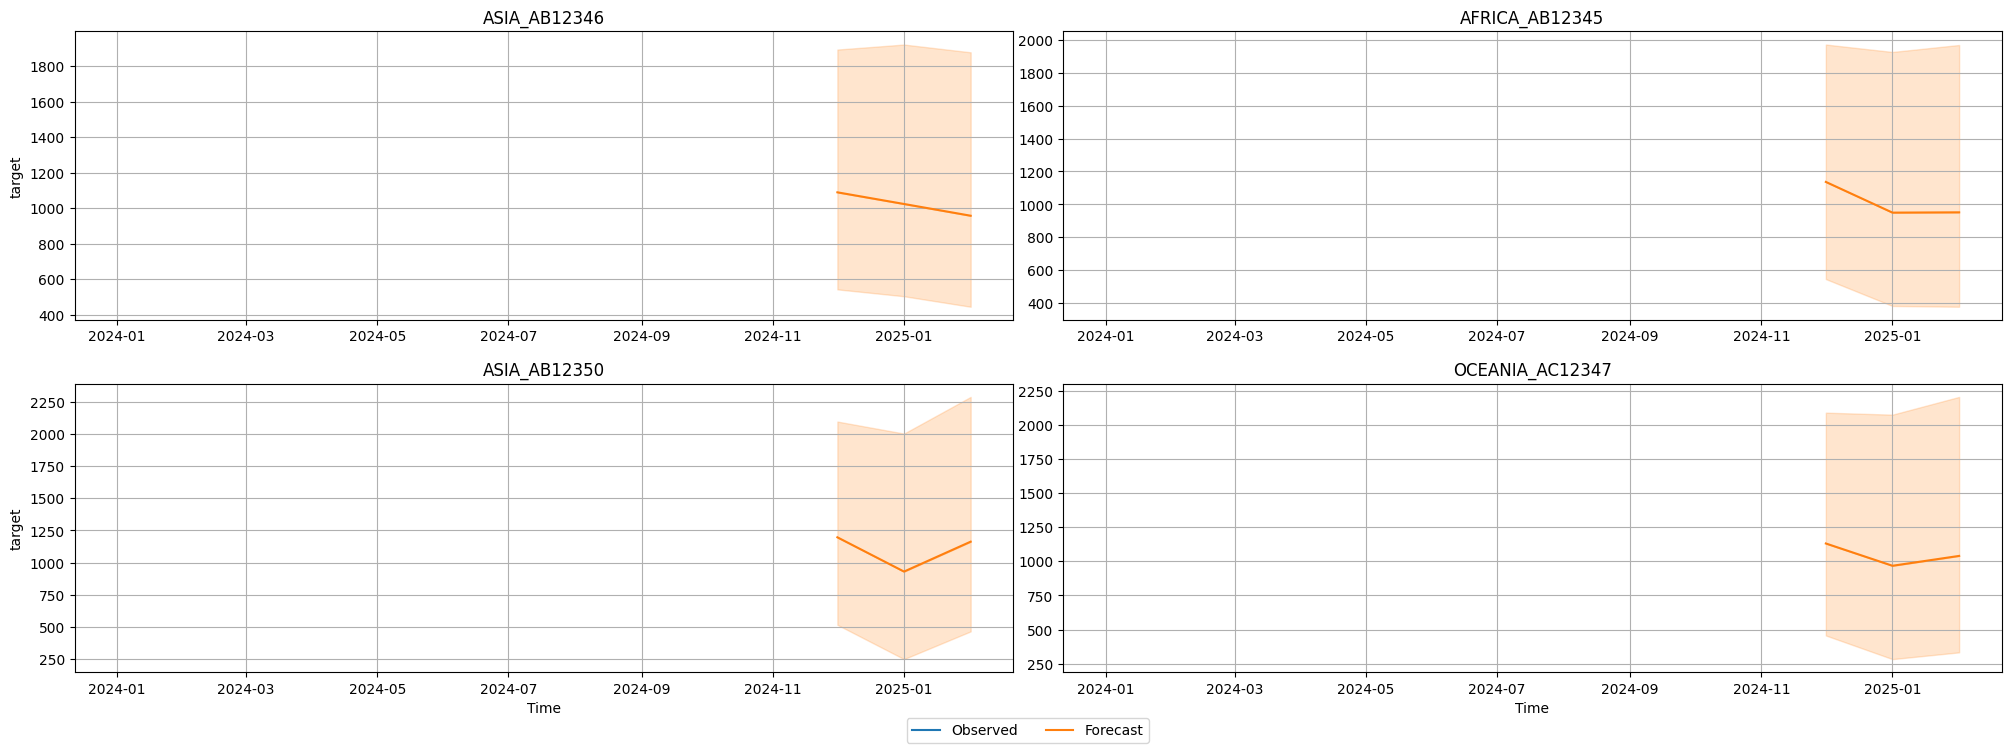

In [318]:
import matplotlib.pyplot as plt
%matplotlib inline
# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame(df_test)
test_data

#Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.2, 0.9], max_history_length=100, max_num_item_ids=4);

In [319]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Theta,-404773.306470,-531522.764220,42.194385,42.057831,0.017593,6
1,SeasonalNaive,-404773.315789,-975042.912281,3.774392,0.072201,0.007438,2
2,RecursiveTabular,-404773.315789,-811831.142285,0.092187,0.151867,1.431211,3
3,Naive,-404773.315789,-849468.596491,0.040572,3.819875,0.022509,1
4,ETS,-404773.315789,-525317.795123,0.056951,2.384438,0.020957,5
5,TemporalFusionTransformer,-404773.853673,-528107.965209,0.113188,0.063712,246.400532,8
6,DirectTabular,-404850.676425,-528909.124273,0.128346,0.116568,1.610022,4
7,WeightedEnsemble,-406312.029242,-502889.696626,2.445995,4.539339,0.641371,9
8,Chronos[bolt_small],-407836.096580,-520760.200770,2.179667,1.939322,0.019713,7
